In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from pathlib import Path

# Load processed data
X = pd.read_csv("../data/processed/genotypes_qc_std.csv", index_col=0)

ph = pd.read_csv("../data/processed/phenotypes_clean.csv")
print("Phenotype columns:", ph.columns.tolist())

# Handle case where cultivar is stored as index column
if "cultivar" in ph.columns:
    pheno = ph.set_index("cultivar")
else:
    # typical case: cultivar saved as index
    pheno = ph.set_index(ph.columns[0])
    pheno.index.name = "cultivar"

# Align phenotype with genotypes
pheno = pheno.loc[X.index]

y = pheno["trait_y"].values
groups = pheno["pop"].values

X.shape, y.shape

Phenotype columns: ['index', 'trait_y', 'pop']


((300, 37363), (300,))

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA to capture genetic structure
pca = PCA(n_components=10, random_state=42)
PC = pca.fit_transform(X.values)

# Cluster lines into genetic origins
k = 10  # realistic number of origins/programs
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
genetic_group = kmeans.fit_predict(PC)

print("Number of genetic groups:", len(np.unique(genetic_group)))
pd.Series(genetic_group).value_counts().sort_index()

Number of genetic groups: 10


0    46
1    24
2    29
3    20
4    40
5    21
6    25
7    28
8    40
9    27
Name: count, dtype: int64

In [3]:
def cross_validate_ridge(X, y, cv, groups=None, alpha=1.0):
    preds = np.zeros_like(y, dtype=float)

    for train, test in cv.split(X, y, groups):
        model = Ridge(alpha=alpha)
        model.fit(X[train], y[train])
        preds[test] = model.predict(X[test])

    r = pearsonr(y, preds)[0]
    rmse = np.sqrt(mean_squared_error(y, preds))
    return r, rmse

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r_kf, rmse_kf = cross_validate_ridge(
    X.values, y, cv=kf
)

r_kf, rmse_kf


(np.float64(0.09373581724792092), np.float64(1.6532052397033874))

In [5]:
gkf = GroupKFold(n_splits=5)

r_gkf, rmse_gkf = cross_validate_ridge(
    X.values, y, cv=gkf, groups=genetic_group
)

r_gkf, rmse_gkf

(np.float64(0.0767309690270043), np.float64(1.6595842882099385))

In [6]:
results = pd.DataFrame({
    "CV": ["KFold (leakage)", "GroupKFold (genetic groups k=10)"],
    "Predictive_Ability_r": [r_kf, r_gkf],
    "RMSE": [rmse_kf, rmse_gkf]
})

results

,CV,Predictive_Ability_r,RMSE
0,KFold (leakage),0.093736,1.653205
1,GroupKFold (genetic groups k=10),0.076731,1.659584


In [7]:
Path("../outputs/tables").mkdir(parents=True, exist_ok=True)
results.to_csv("../outputs/tables/day3_ridge_cv_results.csv", index=False)

print("Saved: ../outputs/tables/day3_ridge_cv_results.csv")
results

Saved: ../outputs/tables/day3_ridge_cv_results.csv


,CV,Predictive_Ability_r,RMSE
0,KFold (leakage),0.093736,1.653205
1,GroupKFold (genetic groups k=10),0.076731,1.659584


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

gs_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

gs_pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('scale', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a 

In [9]:
gs_pipeline.fit(X.values, y)
print("Fitted on:", X.shape[0], "lines and", X.shape[1], "SNPs")

Fitted on: 300 lines and 37363 SNPs


In [10]:
gebv = gs_pipeline.predict(X.values)

ranking = (pd.DataFrame({"cultivar": X.index, "GEBV": gebv})
           .sort_values("GEBV", ascending=False)
           .reset_index(drop=True))

ranking.head(10)

,cultivar,GEBV
0,CULT_065,4.037915
1,CULT_199,4.018210
2,CULT_060,3.881236
3,CULT_063,3.789315
4,CULT_242,3.675231
5,CULT_259,3.381454
6,CULT_188,3.368509
7,CULT_210,3.277920
8,CULT_299,3.246587
9,CULT_038,3.187695


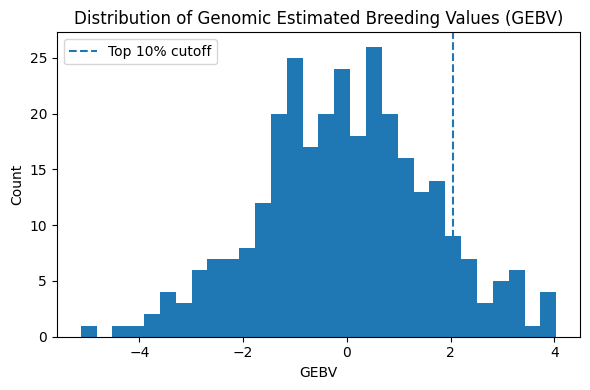

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(gebv, bins=30)
plt.axvline(np.percentile(gebv, 90), linestyle="--", label="Top 10% cutoff")
plt.title("Distribution of Genomic Estimated Breeding Values (GEBV)")
plt.xlabel("GEBV")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def cross_expected_mean(parent_a, parent_b, ranking_df):
    ra = ranking_df.loc[ranking_df["cultivar"] == parent_a, "GEBV"]
    rb = ranking_df.loc[ranking_df["cultivar"] == parent_b, "GEBV"]
    if len(ra) == 0 or len(rb) == 0:
        raise ValueError("Parent cultivar ID not found in ranking.")
    return float(0.5 * (ra.values[0] + rb.values[0]))

parent_A = ranking.loc[0, "cultivar"]
parent_B = ranking.loc[5, "cultivar"]

parent_A, parent_B, cross_expected_mean(parent_A, parent_B, ranking)


('CULT_065', 'CULT_259', 3.7096847025091297)

In [13]:
top_parents = ranking.head(10)["cultivar"].tolist()

crosses = []
for i in range(len(top_parents)):
    for j in range(i+1, len(top_parents)):
        a, b = top_parents[i], top_parents[j]
        crosses.append({
            "cross": f"{a} x {b}",
            "expected_mean_GEBV": cross_expected_mean(a, b, ranking)
        })

cross_df = (pd.DataFrame(crosses)
            .sort_values("expected_mean_GEBV", ascending=False)
            .reset_index(drop=True))

cross_df.head(10)


,cross,expected_mean_GEBV
0,CULT_065 x CULT_199,4.028063
1,CULT_065 x CULT_060,3.959576
2,CULT_199 x CULT_060,3.949723
3,CULT_065 x CULT_063,3.913615
4,CULT_199 x CULT_063,3.903762
5,CULT_065 x CULT_242,3.856573
6,CULT_199 x CULT_242,3.846721
7,CULT_060 x CULT_063,3.835275
8,CULT_060 x CULT_242,3.778234
9,CULT_063 x CULT_242,3.732273


In [14]:
import joblib
from pathlib import Path

Path("../outputs/models").mkdir(parents=True, exist_ok=True)
joblib.dump(gs_pipeline, "../outputs/models/ridge_gs_pipeline.joblib")

print("Saved:", "../outputs/models/ridge_gs_pipeline.joblib")


Saved: ../outputs/models/ridge_gs_pipeline.joblib
